# Summary:
This notebook will cover exploratory data analysis (EDA) of the text file for tweet sentiment extraction.

# Table of contents
* [1. Data cleaning and preprocessing](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Distribution of sentiment](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Distribution of wordcount in text and selected_text for each tweet](#Part1.2_link)
* [2. Explore connections between selected_text and the original text](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Selected_text is part of the original tweet](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Jaccard similarity between text and selected_text for each tweet](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Jaccard similarity score and wordcount](#Part2.3_link)
* [3. Explore keywords for each sentiment](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Text preprocessing](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Generate vocabulary for each sentiment](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Most common words in each sentiment](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 Generate vocabulary for unique words in each sentiment](#Part3.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.5 Most common unique words in each sentiment](#Part3.5_link)
<br >&nbsp;&nbsp;&nbsp;[3.6 Visualize frequent words in each category using WordCloud](#Part3.6_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from palettable.colorbrewer.qualitative import Pastel1_7

from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud

In [2]:
base_dir="/Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction"

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,"train.csv"))
test_df=pd.read_csv(os.path.join(base_dir,"test.csv"))

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


<a id='Part1_link'></a>
# 1. Data cleaning and preprocessing

In [6]:
train_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
print("training set: {}".format(train_df.shape))
print("testing set: {}".format(test_df.shape))
train_df.dropna(inplace=True)
print("training set after removing NA: {}".format(train_df.shape))

training set: (27481, 4)
testing set: (3534, 3)
training set after removing NA: (27480, 4)


<a id='Part1.1_link'></a>
## 1.1 Distribution of sentiment

In [9]:
sentiment_df=train_df.sentiment.value_counts().to_frame()
sentiment_df

,sentiment
neutral,11117
positive,8582
negative,7781


In [10]:
sentiment_df.style.background_gradient(cmap='Purples')

,sentiment
neutral,11117
positive,8582
negative,7781


Text(0.5, 1.0, 'Number of tweets in each sentiment')

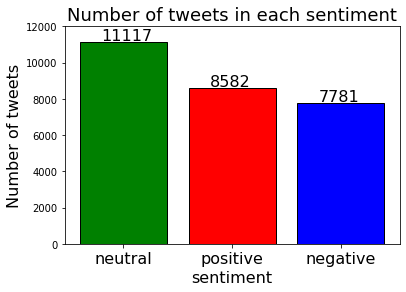

In [16]:
colors=["green","red","blue"]
plt.bar(sentiment_df.index,sentiment_df.sentiment,color=colors,edgecolor="black")
plt.xticks(fontsize=16)
plt.xlabel("sentiment",fontsize=16)
plt.ylim(0,12000)
plt.ylabel("Number of tweets",fontsize=16)
for i in range(3):
    plt.text(i-0.2,sentiment_df.sentiment.values[i]+100,sentiment_df.sentiment.values[i],fontsize=16)
plt.title("Number of tweets in each sentiment",fontsize=18)

<a id='Part1.2_link'></a>
## 1.2 Distribution of wordcount in text and selected_text for each tweet

In [20]:
train_df["text_count"]=train_df.text.apply(lambda x:len(str(x).strip().split()))
train_df["selectedtext_count"]=train_df.selected_text.apply(lambda x:len(str(x).strip().split()))
train_df["diff_count"]=train_df.apply(lambda x:x.text_count-x.selectedtext_count,axis=1)

In [21]:
train_df.loc[:,["text_count","selectedtext_count","diff_count"]].describe()

,text_count,selectedtext_count,diff_count
count,27480.000000,27480.000000,27480.000000
mean,12.902875,7.102511,5.800364
std,6.925938,6.891179,7.249036
min,1.000000,1.000000,0.000000
25%,7.000000,1.000000,0.000000
50%,12.000000,4.000000,2.000000
75%,18.000000,11.000000,11.000000
max,33.000000,33.000000,31.000000


Text(0.5, 1.0, 'Distribution of wordcount in text')

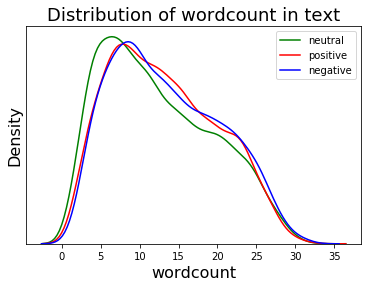

In [32]:
colors=["green","red","blue"]
sns.distplot(train_df[train_df.sentiment=="neutral"].text_count,bins=100,color=colors[0],hist=False,label="neutral")
sns.distplot(train_df[train_df.sentiment=="positive"].text_count,bins=100,color=colors[1],hist=False,label="positive")
sns.distplot(train_df[train_df.sentiment=="negative"].text_count,bins=100,color=colors[2],hist=False,label="negative")
plt.xlabel("wordcount",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Distribution of wordcount in text",fontsize=18)
#plt.legend(bbox_to_anchor=(1.4,1))

Text(0.5, 1.0, 'Distribution of wordcount in selected text')

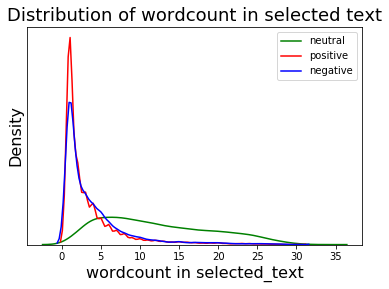

In [33]:
colors=["green","red","blue"]
sns.distplot(train_df[train_df.sentiment=="neutral"].selectedtext_count,bins=100,color=colors[0],hist=False,label="neutral")
sns.distplot(train_df[train_df.sentiment=="positive"].selectedtext_count,bins=100,color=colors[1],hist=False,label="positive")
sns.distplot(train_df[train_df.sentiment=="negative"].selectedtext_count,bins=100,color=colors[2],hist=False,label="negative")
plt.xlabel("wordcount in selected_text",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Distribution of wordcount in selected text",fontsize=18)
#plt.legend(bbox_to_anchor=(1.5,1))

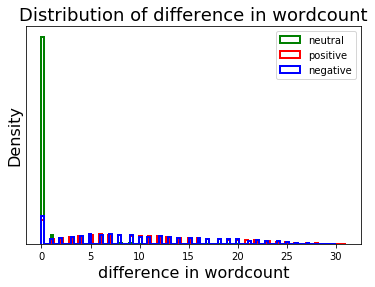

In [37]:
colors=["green","red","blue"]
plt.hist(train_df[train_df.sentiment=="neutral"].diff_count,bins=100,histtype="step",density=True,color=colors[0],label="neutral",linewidth=2)
plt.hist(train_df[train_df.sentiment=="positive"].diff_count,bins=100,histtype="step",density=True,color=colors[1],label="positive",linewidth=2)
plt.hist(train_df[train_df.sentiment=="negative"].diff_count,bins=100,histtype="step",density=True,color=colors[2],label="negative",linewidth=2)
plt.xlabel("difference in wordcount",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Distribution of difference in wordcount",fontsize=18)
plt.legend()
#plt.legend(bbox_to_anchor=(1.4,1))

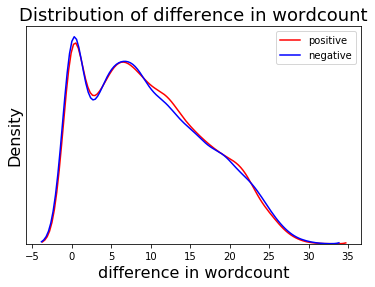

In [39]:
colors=["green","red","blue"]
sns.distplot(train_df[train_df.sentiment=="positive"].diff_count,bins=100,color=colors[1],hist=False,label="positive")
sns.distplot(train_df[train_df.sentiment=="negative"].diff_count,bins=100,color=colors[2],hist=False,label="negative")
plt.xlabel("difference in wordcount",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Distribution of difference in wordcount",fontsize=18)
plt.legend()
#plt.legend(bbox_to_anchor=(1.5,1))

<a id='Part2_link'></a>
# 2. Explore connections between selected_text and the original text

<a id='Part2.1_link'></a>
## 2.1 Selected_text is part of the original tweet

**Note**: First we need to confirm that all the selected_text is part of the original tweet

In [17]:
train_df["start"]=train_df.apply(lambda x:x.text.find(x.selected_text),axis=1)

In [18]:
## All selected_text can be found in text
sum(train_df["start"]>=0)

27480

<a id='Part2.2_link'></a>
## 2.2 Jaccard similarity between text and selected_text for each tweet

In [40]:
def compute_jaccard_similarity(sent1,sent2):
    sents1=sent_tokenize(str(sent1).lower().strip())
    sents2=sent_tokenize(str(sent2).lower().strip())
    a=set()
    for sent in sents1:
        tokens=sent.split()
        a=a.union(set(tokens))
    b=set()
    for sent in sents2:
        tokens=sent.split()
        b=b.union(set(tokens))
    return len(a.intersection(b))/len(a.union(b))

In [41]:
train_df["jaccard_similarity"]=train_df.apply(lambda x:compute_jaccard_similarity(x.text,x.selected_text),axis=1)

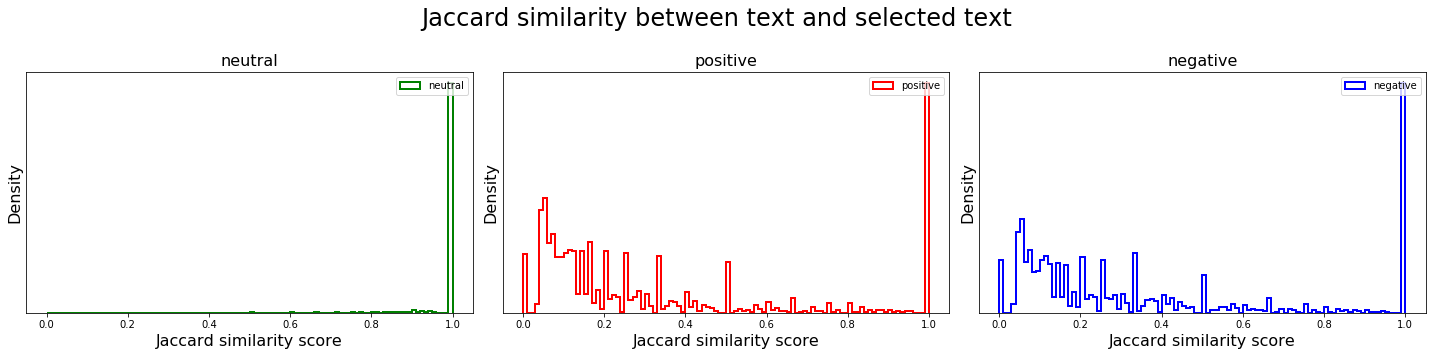

In [48]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sentiments=["neutral","positive","negative"]
colors=["green","red","blue"]
for i in range(3):
    sentiment=sentiments[i]
    axes[i].hist(train_df[train_df.sentiment==sentiment]["jaccard_similarity"],bins=100,histtype="step",color=colors[i],density=True,label=sentiment,linewidth=2)
    axes[i].set_xlabel("Jaccard similarity score",fontsize=16)
    axes[i].set_yticks([])
    axes[i].set_ylabel("Density",fontsize=16)
    axes[i].set_title(sentiment,fontsize=16)
    axes[i].legend()
fig.suptitle("Jaccard similarity between text and selected text",fontsize=24)
plt.tight_layout()
fig.subplots_adjust(top=0.8)

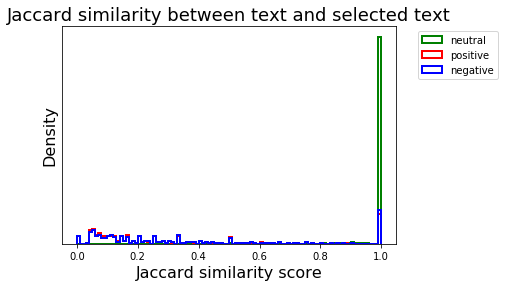

In [49]:
colors=["green","red","blue"]
plt.hist(train_df[train_df.sentiment=="neutral"].jaccard_similarity,bins=100,histtype="step",density=True,color=colors[0],label="neutral",linewidth=2)
plt.hist(train_df[train_df.sentiment=="positive"].jaccard_similarity,bins=100,histtype="step",density=True,color=colors[1],label="positive",linewidth=2)
plt.hist(train_df[train_df.sentiment=="negative"].jaccard_similarity,bins=100,histtype="step",density=True,color=colors[2],label="negative",linewidth=2)
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity between text and selected text",fontsize=18)
plt.legend(bbox_to_anchor=(1.05,1))

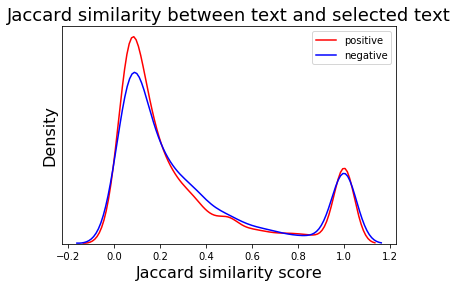

In [50]:
colors=["green","red","blue"]
sns.distplot(train_df[train_df.sentiment=="positive"].jaccard_similarity,bins=100,color=colors[1],hist=False,label="positive")
sns.distplot(train_df[train_df.sentiment=="negative"].jaccard_similarity,bins=100,color=colors[2],hist=False,label="negative")
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity between text and selected text",fontsize=18)
plt.legend()
#plt.legend(bbox_to_anchor=(1.5,1))

In [107]:
jaccard_df=train_df.groupby(["sentiment"]).mean()[["jaccard_similarity"]]
jaccard_df

,jaccard_similarity
sentiment,
negative,0.338417
neutral,0.976423
positive,0.314021


<a id='Part2.3_link'></a>
## 2.3 Jaccard similarity score and wordcount

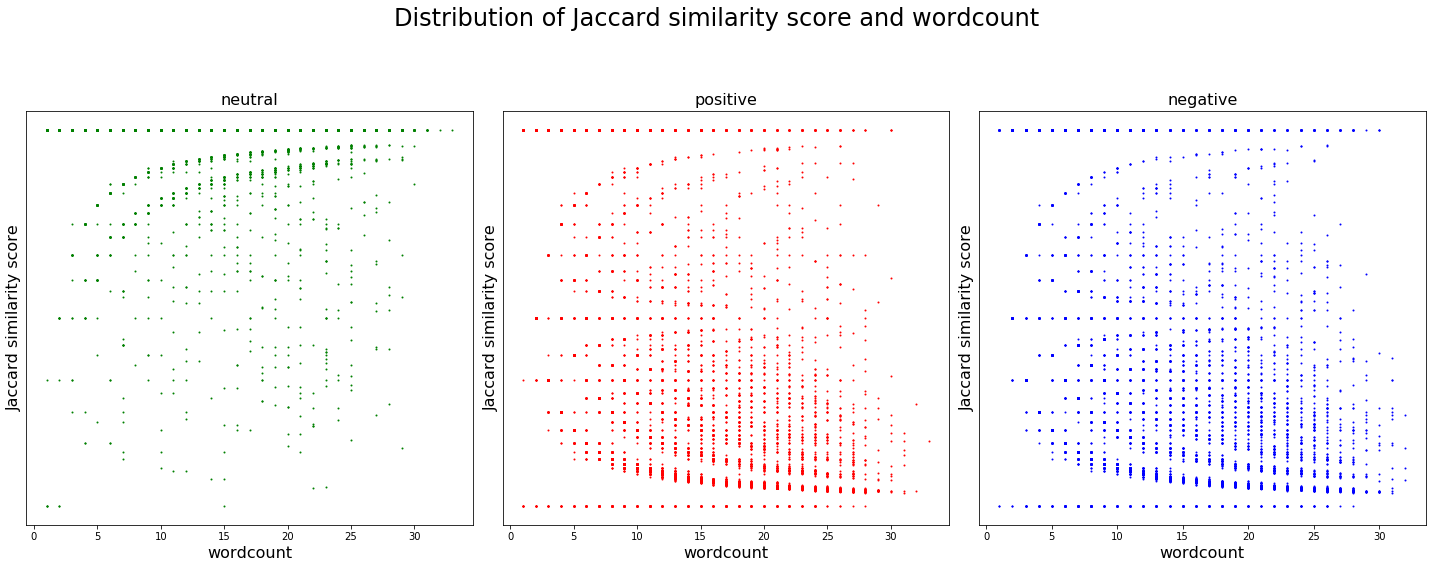

In [53]:
fig,axes=plt.subplots(1,3,figsize=(20,8))
sentiments=["neutral","positive","negative"]
colors=["green","red","blue"]
for i in range(3):
    sentiment=sentiments[i]
    axes[i].scatter(train_df[train_df.sentiment==sentiment]["text_count"],train_df[train_df.sentiment==sentiment]["jaccard_similarity"],alpha=1,color=colors[i],s=1)
    axes[i].set_xlabel("wordcount",fontsize=16)
    axes[i].set_yticks([])
    axes[i].set_ylabel("Jaccard similarity score",fontsize=16)
    axes[i].set_title(sentiment,fontsize=16)
fig.suptitle("Distribution of Jaccard similarity score and wordcount",fontsize=24)
plt.tight_layout()
fig.subplots_adjust(top=0.8)

<a id='Part3_link'></a>
# 3. Explore keywords for each sentiment

<a id='Part3.1_link'></a>
## 3.1 Text preprocessing

In [54]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
#stop_words = set(list(stop_word1)+stop_word2+list(punctuation))   ## 390+32=422
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
stop_words = set(list(stop_word1)+stop_word2+list(punct)+["wa"])
print(len(stop_words))

449


In [55]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [56]:
train_df["text_clean"]=train_df.text.apply(lambda x:preprocess(x))
train_df["selected_text_clean"]=train_df.selected_text.apply(lambda x:preprocess(x))

In [57]:
train_df.head()

,textID,text,selected_text,sentiment,start,text_count,selectedtext_count,diff_count,jaccard_similarity,text_clean,selected_text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1,7,7,0,1.000000,"[responded, going]","[responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,10,2,8,0.181818,"[sooo, sad, miss, san, diego]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,11,5,2,3,0.166667,"[bos, bullying]",[bullying]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,17,5,3,2,0.600000,"[interview, leave]",[leave]
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1,14,3,11,0.214286,"[son, release, bought]",[son]


<a id='Part3.2_link'></a>
## 3.2 Generate vocabulary for each sentiment

In [222]:
counts_neutral=Counter(train_df[train_df.sentiment=="neutral"]["text_clean"].sum())
counts_positive=Counter(train_df[train_df.sentiment=="positive"]["text_clean"].sum())
counts_negative=Counter(train_df[train_df.sentiment=="negative"]["text_clean"].sum())
counts_selected_neutral=Counter(train_df[train_df.sentiment=="neutral"]["selected_text_clean"].sum())
counts_selected_positive=Counter(train_df[train_df.sentiment=="positive"]["selected_text_clean"].sum())
counts_selected_negative=Counter(train_df[train_df.sentiment=="negative"]["selected_text_clean"].sum())

In [229]:
counts_neutral_df=pd.DataFrame.from_records(counts_neutral.most_common()).rename(columns={0:"token",1:"count"})
counts_positive_df=pd.DataFrame.from_records(counts_positive.most_common()).rename(columns={0:"token",1:"count"})
counts_negative_df=pd.DataFrame.from_records(counts_negative.most_common()).rename(columns={0:"token",1:"count"})
counts_selected_neutral_df=pd.DataFrame.from_records(counts_selected_neutral.most_common()).rename(columns={0:"token",1:"count"})
counts_selected_positive_df_=pd.DataFrame.from_records(counts_selected_positive.most_common()).rename(columns={0:"token",1:"count"})
counts_selected_negative_df=pd.DataFrame.from_records(counts_selected_negative.most_common()).rename(columns={0:"token",1:"count"})


In [230]:
counts_neutral_df.to_csv(os.path.join(base_dir,"counts_df/counts_neutral_df.csv"),index=False)
counts_positive_df.to_csv(os.path.join(base_dir,"counts_df/counts_positive_df.csv"),index=False)
counts_negative_df.to_csv(os.path.join(base_dir,"counts_df/counts_negative_df.csv"),index=False)
counts_selected_neutral_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_neutral_df.csv"),index=False)
counts_selected_positive_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_positive_df.csv"),index=False)
counts_selected_negative_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_negative_df.csv"),index=False)

In [231]:
print("Vocabulary size in neutral text: {}".format(counts_neutral_df.shape[0]))
print("Vocabulary size in positive text: {}".format(counts_positive_df.shape[0]))
print("Vocabulary size in negative text: {}".format(counts_negative_df.shape[0]))

print("Vocabulary size in neutral selected_text: {}".format(counts_selected_neutral_df.shape[0]))
print("Vocabulary size in positive selected_text: {}".format(counts_selected_positive_df.shape[0]))
print("Vocabulary size in negative selected_text: {}".format(counts_selected_negative_df.shape[0]))

Vocabulary size in neutral text: 12781
Vocabulary size in positive text: 10232
Vocabulary size in negative text: 9885
Vocabulary size in neutral selected_text: 12470
Vocabulary size in positive selected_text: 3409
Vocabulary size in negative selected_text: 3998


<a id='Part3.3_link'></a>
## 3.3 Most common words in each sentiment

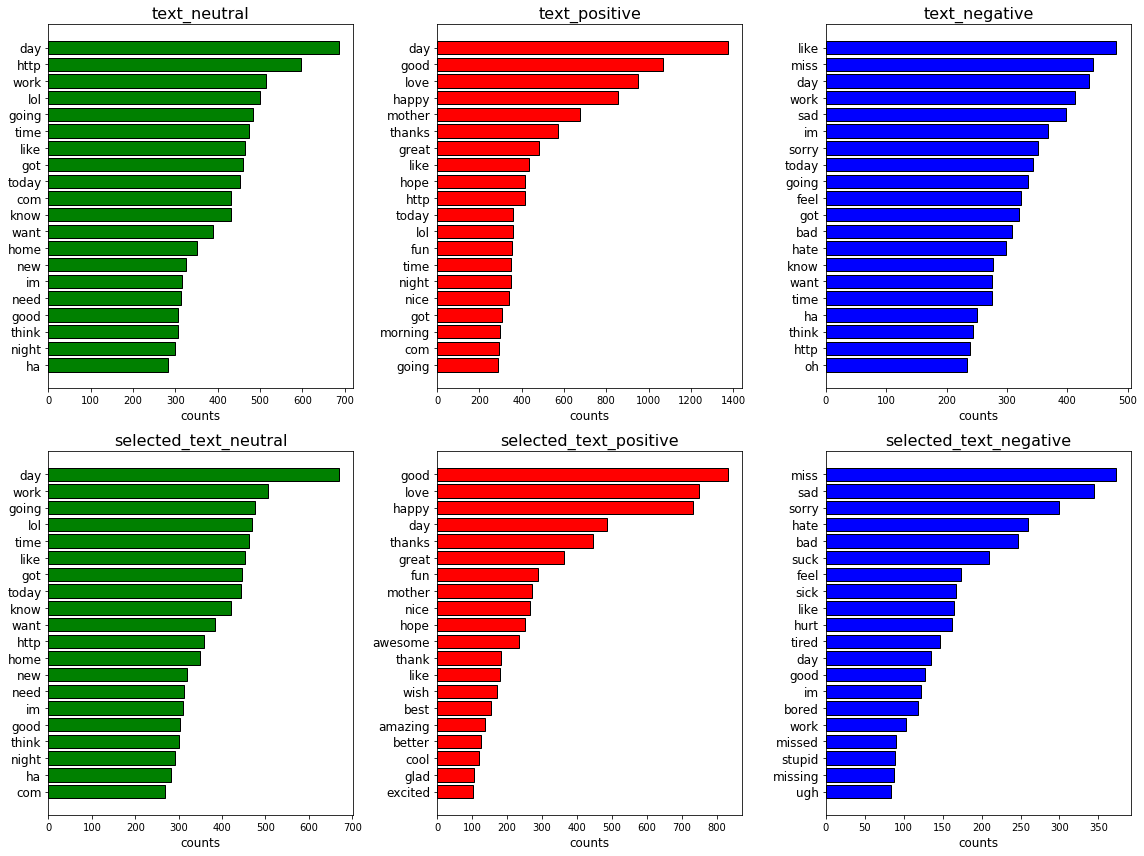

In [232]:
file_list1=[counts_neutral_df,counts_positive_df,counts_negative_df,
            counts_selected_neutral_df,counts_selected_positive_df,counts_selected_negative_df]
filename_list1=["text_neutral","text_positive","text_negative","selected_text_neutral","selected_text_positive","selected_text_negative"]
colors=["green","red","blue"]

fig,axes=plt.subplots(2,3,figsize=(16,12))
for i in range(6):
    file=file_list1[i]
    axes[i//3][i%3].barh(file.iloc[:20,:].token,file.iloc[:20,:]["count"],color=colors[i%3],edgecolor="black")
    axes[i//3][i%3].set_xlabel("counts",fontsize=12)
    axes[i//3][i%3].set_yticklabels(file.iloc[:20,:].token,fontsize=12)
    axes[i//3][i%3].invert_yaxis()
    axes[i//3][i%3].set_title(filename_list1[i],fontsize=16)
plt.tight_layout()  

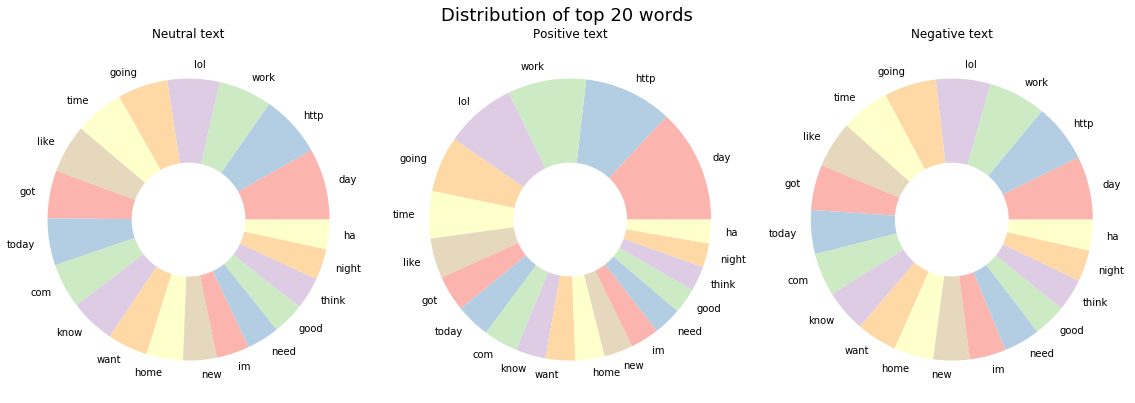

In [233]:
fig,axes=plt.subplots(1,3,figsize=(16,6))
my_circle1=plt.Circle((0,0),0.4,color="white")
my_circle2=plt.Circle((0,0),0.4,color="white")
my_circle3=plt.Circle((0,0),0.4,color="white")
axes[0].pie(counts_neutral_df.iloc[:20,:]["count"],radius=1,labels=counts_neutral_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[1].pie(counts_positive_df.iloc[:20,:]["count"],radius=1,labels=counts_neutral_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[2].pie(counts_negative_df.iloc[:20,:]["count"],radius=1,labels=counts_neutral_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[0].add_artist(my_circle1)
axes[1].add_artist(my_circle2)
axes[2].add_artist(my_circle3)
axes[0].set_title("Neutral text")
axes[1].set_title("Positive text")
axes[2].set_title("Negative text")
fig.suptitle("Distribution of top 20 words",fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

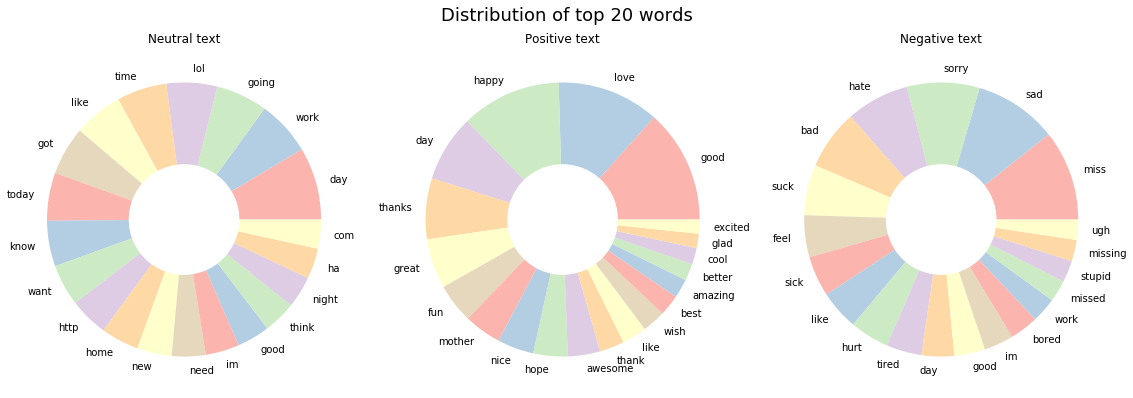

In [234]:
fig,axes=plt.subplots(1,3,figsize=(16,6))
my_circle1=plt.Circle((0,0),0.4,color="white")
my_circle2=plt.Circle((0,0),0.4,color="white")
my_circle3=plt.Circle((0,0),0.4,color="white")
axes[0].pie(counts_selected_neutral_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_neutral_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[1].pie(counts_selected_positive_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_positive_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[2].pie(counts_selected_negative_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_negative_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[0].add_artist(my_circle1)
axes[1].add_artist(my_circle2)
axes[2].add_artist(my_circle3)
axes[0].set_title("Neutral text")
axes[1].set_title("Positive text")
axes[2].set_title("Negative text")
fig.suptitle("Distribution of top 20 words",fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

<a id='Part3.4_link'></a>
## 3.4 Generate vocabulary for unique words in each sentiment

In [175]:
counts_neutral_df.index=counts_neutral_df.token
counts_neutral_unique_df=counts_neutral_df.loc[set(counts_neutral_df.token)-set(counts_positive_df.token)-set(counts_negative_df.token)].sort_values(by=["count"],ascending=False)
counts_positive_df.index=counts_positive_df.token
counts_positive_unique_df=counts_positive_df.loc[set(counts_positive_df.token)-set(counts_neutral_df.token)-set(counts_negative_df.token)].sort_values(by=["count"],ascending=False)
counts_negative_df.index=counts_negative_df.token
counts_negative_unique_df=counts_negative_df.loc[set(counts_negative_df.token)-set(counts_neutral_df.token)-set(counts_positive_df.token)].sort_values(by=["count"],ascending=False)
counts_selected_neutral_df.index=counts_selected_neutral_df.token
counts_selected_neutral_unique_df=counts_selected_neutral_df.loc[set(counts_selected_neutral_df.token)-set(counts_selected_positive_df.token)-set(counts_selected_negative_df.token)].sort_values(by=["count"],ascending=False)
counts_selected_positive_df.index=counts_selected_positive_df.token
counts_selected_positive_unique_df=counts_selected_positive_df.loc[set(counts_selected_positive_df.token)-set(counts_selected_neutral_df.token)-set(counts_selected_negative_df.token)].sort_values(by=["count"],ascending=False)
counts_selected_negative_df.index=counts_selected_negative_df.token
counts_selected_negative_unique_df=counts_selected_negative_df.loc[set(counts_selected_negative_df.token)-set(counts_selected_neutral_df.token)-set(counts_selected_positive_df.token)].sort_values(by=["count"],ascending=False)


In [235]:
counts_neutral_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_neutral_unique_df.csv"),index=False)
counts_positive_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_positive_unique_df.csv"),index=False)
counts_negative_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_negative_unique_df.csv"),index=False)
counts_selected_neutral_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_neutral_unique_df.csv"),index=False)
counts_selected_positive_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_positive_unique_df.csv"),index=False)
counts_selected_negative_unique_df.to_csv(os.path.join(base_dir,"counts_df/counts_selected_negative_unique_df.csv"),index=False)

In [236]:
print("Unique tokens in neutral text: {}".format(counts_neutral_unique_df.shape[0]))
print("Unique tokens in positive text: {}".format(counts_positive_unique_df.shape[0]))
print("Unique tokens in negative text: {}".format(counts_negative_unique_df.shape[0]))
print("Unique tokens in neutral selected_text: {}".format(counts_selected_neutral_unique_df.shape[0]))
print("Unique tokens in positive selected_text: {}".format(counts_selected_positive_unique_df.shape[0]))
print("Unique tokens in negative selected_text: {}".format(counts_selected_negative_unique_df.shape[0]))

Unique tokens in neutral text: 6152
Unique tokens in positive text: 4389
Unique tokens in negative text: 4040
Unique tokens in neutral selected_text: 8859
Unique tokens in positive selected_text: 1078
Unique tokens in negative selected_text: 1338


<a id='Part3.5_link'></a>
## 3.5 Most common unique words in each sentiment

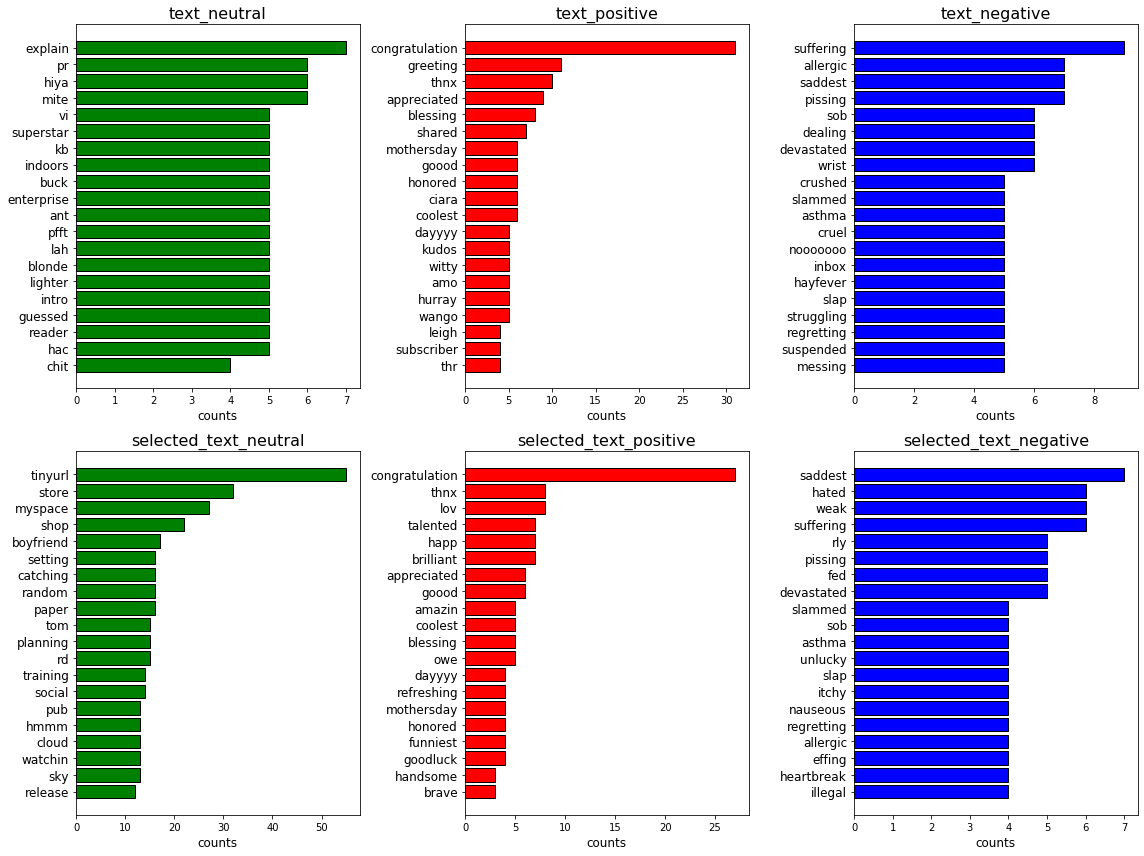

In [237]:
file_list2=[counts_neutral_unique_df,counts_positive_unique_df,counts_negative_unique_df,
           counts_selected_neutral_unique_df,counts_selected_positive_unique_df,counts_selected_negative_unique_df]
filename_list2=["text_neutral_unique","text_positive_unique","text_negative_unique","selected_text_neutral_unique","selected_text_positive_unique","selected_text_negative_unique"]
colors=["green","red","blue"]

fig,axes=plt.subplots(2,3,figsize=(16,12))
for i in range(6):
    file=file_list2[i]
    axes[i//3][i%3].barh(file.iloc[:20,:].token,file.iloc[:20,:]["count"],color=colors[i%3],edgecolor="black")
    axes[i//3][i%3].set_xlabel("counts",fontsize=12)
    axes[i//3][i%3].set_yticklabels(file.iloc[:20,:].token,fontsize=12)
    axes[i//3][i%3].invert_yaxis()
    axes[i//3][i%3].set_title(filename_list1[i],fontsize=16)
plt.tight_layout()  

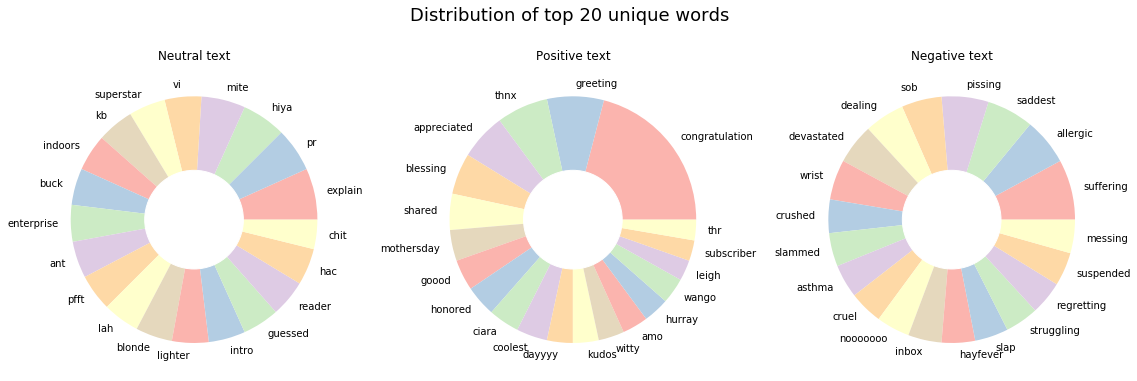

In [238]:
fig,axes=plt.subplots(1,3,figsize=(16,6))
my_circle1=plt.Circle((0,0),0.4,color="white")
my_circle2=plt.Circle((0,0),0.4,color="white")
my_circle3=plt.Circle((0,0),0.4,color="white")
axes[0].pie(counts_neutral_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_neutral_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[1].pie(counts_positive_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_positive_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[2].pie(counts_negative_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_negative_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[0].add_artist(my_circle1)
axes[1].add_artist(my_circle2)
axes[2].add_artist(my_circle3)
axes[0].set_title("Neutral text")
axes[1].set_title("Positive text")
axes[2].set_title("Negative text")
fig.suptitle("Distribution of top 20 unique words",fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

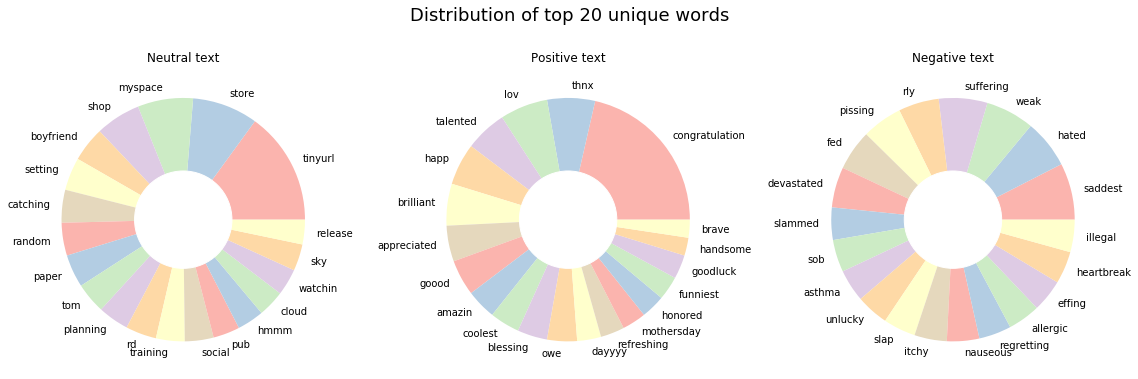

In [239]:
fig,axes=plt.subplots(1,3,figsize=(16,6))
my_circle1=plt.Circle((0,0),0.4,color="white")
my_circle2=plt.Circle((0,0),0.4,color="white")
my_circle3=plt.Circle((0,0),0.4,color="white")
axes[0].pie(counts_selected_neutral_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_neutral_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[1].pie(counts_selected_positive_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_positive_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[2].pie(counts_selected_negative_unique_df.iloc[:20,:]["count"],radius=1,labels=counts_selected_negative_unique_df.iloc[:20,:].token,colors=Pastel1_7.hex_colors)
axes[0].add_artist(my_circle1)
axes[1].add_artist(my_circle2)
axes[2].add_artist(my_circle3)
axes[0].set_title("Neutral text")
axes[1].set_title("Positive text")
axes[2].set_title("Negative text")
fig.suptitle("Distribution of top 20 unique words",fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

<a id='Part3.6_link'></a>
## 3.6 Visualize frequent words in each category using WordCloud

In [61]:
train_neutral_df=train_df[train_df.sentiment=="neutral"]
train_neutral_df["corpus1"]=train_neutral_df.text_clean.apply(lambda x: " ".join(x))
train_neutral_df["corpus2"]=train_neutral_df.selected_text_clean.apply(lambda x: " ".join(x))

train_positive_df=train_df[train_df.sentiment=="positive"]
train_positive_df["corpus1"]=train_positive_df.text_clean.apply(lambda x: " ".join(x))
train_positive_df["corpus2"]=train_positive_df.selected_text_clean.apply(lambda x: " ".join(x))

train_negative_df=train_df[train_df.sentiment=="negative"]
train_negative_df["corpus1"]=train_negative_df.text_clean.apply(lambda x: " ".join(x))
train_negative_df["corpus2"]=train_negative_df.selected_text_clean.apply(lambda x: " ".join(x))

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

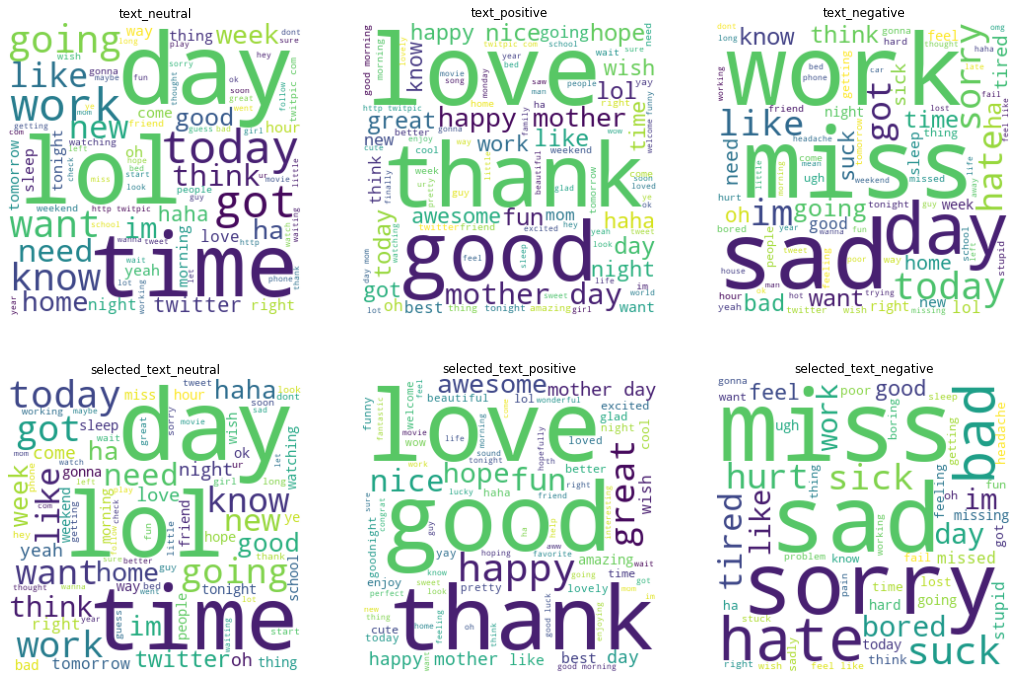

In [62]:
file_list3=[train_neutral_df,train_positive_df,train_negative_df]
filename_list1=["text_neutral","text_positive","text_negative","selected_text_neutral","selected_text_positive","selected_text_negative"]

fig,axes=plt.subplots(2,3,figsize=(18,12))
for i in range(6):
    file=file_list3[i%3]
    wc = WordCloud(stopwords=stop_words,
                   max_words=500,
                   max_font_size=100,
                   min_font_size=8,
                   width=300,
                   height=300,
                   background_color="white",
                   random_state=42,
                   mode="RGBA").generate(" ".join(file["corpus{}".format(i//3+1)]))
    axes[i//3][i%3].imshow(wc, interpolation="bilinear")
    axes[i//3][i%3].axis("off")
    axes[i//3][i%3].set_title(filename_list1[i])
plt.savefig(os.path.join(base_dir, 'wordcloud/text_wordcloud.png'.format(i)))

In [243]:
train_df.head()

,textID,text,selected_text,sentiment,jaccard_similarity,text_count,selectedtext_count,diff_count,text_clean,selected_text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0,"[responded, going]","[responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.181818,10,2,8,"[sooo, sad, miss, san, diego]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2,3,"[bos, bullying]",[bullying]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3,2,"[interview, leave]",[leave]
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14,3,11,"[son, release, bought]",[son]


In [245]:
train_df.to_csv(os.path.join(base_dir,"train_process1_df.csv"),index=False)